# 2.1 Document Clustering with Key Words Extraction (TF-IDF Weightage)

## 2.1.1 Data Import

#### Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import copy

import nltk
import gensim
from nltk.stem.porter import PorterStemmer
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt

#### Loading Train and Test Dataset from CSV

In [91]:
train_dataset = pd.read_csv("./TrainTest_Dataset/train_dataset.csv", keep_default_na=False, na_values=[""])
test_dataset = pd.read_csv("./TrainTest_Dataset/test_dataset.csv", keep_default_na=False, na_values=[""])

## 2.1.2 Training Data Pre-Processing

#### Preparing Training Corpus and Pre-Processing Training Data

In [32]:
train_corpus = nltk.corpus.PlaintextCorpusReader("./TrainTest_Transcripts/Train", ".+\.txt")
train_fids = train_corpus.fileids()

In [18]:
# Preparing List of Stop Words and Stemming using NLTK Library 
stop_list = nltk.corpus.stopwords.words("english")
stemmer = nltk.stem.porter.PorterStemmer()

trainData_tokenized = [corpus.words(fid) for fid in train_fids] 
trainData_lowerCase = [[w.lower() for w in doc] for doc in trainData_tokenized]
trainData_removedPunct = [[w for w in doc if re.search('^[a-z]+$', w)] for doc in trainData_lowerCase]
trainData_removedStopwords = [[w for w in doc if w not in stop_list] for doc in trainData_removedPunct]
trainData_processed = [[stemmer.stem(w) for w in doc] for doc in trainData_removedStopwords]

#### Converting Train Data into Sparse Vector with TF-IDF Weightage 

In [136]:
# Word dictionary 
dict_train = gensim.corpora.Dictionary(trainData_processed)

# Bag of Words Vector 
bowVec_train = [dict_train.doc2bow(doc) for doc in trainData_processed] 

# TF*IDF Model for Training Data 
tfidfModel_train = gensim.models.TfidfModel(bowVec_train) 

# Sparse Vector with TFIDF Weightage
SparseVec_train = [tfidfModel_train[vec] for vec in bowVec_train] 

#### Extracting Top-N Weighted Words from each Document 

In [201]:
# Function to extract top-N words from Document
def Extract_Doc_Top_N_Tfidf_Words(orginal_list, TopNWords):
    # Sort each document word's TF-IDF weightage (list of tuples) in descending order 
    updated_list = copy.deepcopy(orginal_list)
    doc_index = 0 
    for index in range(0,len(updated_list)):
        updated_list[index].sort(key = lambda x: x[1], reverse=True)
        updated_list[index] = updated_list[index][:TopNWords] # Extract the top 100 weighted words  
        doc_index += 1
    return updated_list  

# Function to determine the number unique words from Sparse Vector
def Create_New_Dictionary(sparseVec, original_dict):
    # Converting Bag of Words ID in sparseVec into a list of Tokens 
    # E.g. list of "list of string" e.g. [['SMU','SU'],['Graduate','Wow']]
    tokenized_list = [[original_dict.get(tup[0]) for tup in doc] for doc in sparseVec] 
    return gensim.corpora.Dictionary(tokenized_list)

# Function to create new Sparse Vector based on the new dictionary 
def Create_New_Sparse_Vector(sparseVec, new_dictionary, old_dictionary):    
    # Inverting Dictionary Key and Value for new_dictionary for easier retrieval
    # From [{word_id : word}] to [{word : word_id}]
    inverted_dict = dict(zip(new_dictionary.values(), new_dictionary.keys()))
    new_sparseVec = []
    for doc in sparseVec:
        new_doc = []
        for tup in doc:
            word = old_dictionary.get(tup[0]) # retrieve word from old_dictionary          
            new_doc.append((inverted_dict.get(word),tup[1]))
        new_sparseVec.append(new_doc)
    return new_sparseVec

In [246]:
# Sparse Vector with top-N TF-IDF words from each document. 
# Keep in mind that this contains Word ID of the previous Dictionary  
extracted_SparseVec_train = Extract_Doc_Top_N_Tfidf_Words(SparseVec_train, 15) 

# Creating new set of Dictionary  
new_dict_train = Create_New_Dictionary(extracted_SparseVec_train, dict_train)

# Updating Sparse Vector's word ID 
new_SparseVec_train = Create_New_Sparse_Vector(extracted_SparseVec_train, new_dict_train, dict_train)

# Transforming Sparse Vector into np array to find optimal K 
train_nparray = gensim.matutils.corpus2dense(new_SparseVec_train, len(new_dict_train))

In [247]:
print(len(new_dict_train))

11891


## 2.1.3 Data Clustering

### 2.1.3.1 Identifying Optimal K 
Adapted from: https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f

In [ ]:
Sum_of_squared_distances = []
K = range(1,200)
for k in K:
    print("running: ", k)
    km = KMeans(n_clusters=k)
    km = km.fit(train_nparray)
    Sum_of_squared_distances.append(km.inertia_)

running:  1
running:  2
running:  3
running:  4
running:  5
running:  6
running:  7
running:  8
running:  9
running:  10
running:  11
running:  12
running:  13
running:  14
running:  15
running:  16
running:  17
running:  18
running:  19
running:  20
running:  21
running:  22
running:  23
running:  24
running:  25
running:  26
running:  27
running:  28
running:  29
running:  30
running:  31
running:  32
running:  33
running:  34
running:  35
running:  36
running:  37
running:  38
running:  39
running:  40
running:  41
running:  42
running:  43
running:  44


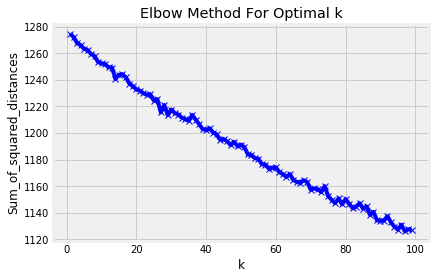

In [218]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

## 2. K-Means Clustering

In [56]:
import k_means

num_tokens = len(dictionary.token2id)
clusters = k_means.k_means(vecs2, num_tokens, 70)

# Document Retrieval

In [ ]:
from gensim import similarities

# DOCUMENT RETRIEVAL????
similarity_index = similarities.SparseMatrixSimilarity(vecs1, len(dictionary))

test_vector = vecs1[100]
sims = similarity_index[test_vector]
sorted_sims = sorted(enumerate(sims), key = lambda item: -item[1])

print(list(enumerate(sorted_sims)))

## Archieved - Ignore the Below

In [ ]:
import numpy as np # linear algebra
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
import string
import kmeans


import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline
plt.style.use('fivethirtyeight')


metadata_dataset = pd.read_csv("../Processed_Dataset/cleaned_dataset.csv", keep_default_na=False, na_values=[""])

data = metadata_dataset['transcript']

tfidf = TfidfVectorizer(
    max_features = 8000,
    stop_words = 'english',
     

tfidf.fit(data)
text = tfidf.transform(data)

print(type(tfid))

# def find_optimal_clusters(data, max_k):
#     iters = range(2, max_k+1, 2)
    
#     sse = []
#     for k in iters:
#         sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
#         print('Fit {} clusters'.format(k))
        
#     f, ax = plt.subplots(1, 1)
#     ax.plot(iters, sse, marker='o')
#     ax.set_xlabel('Cluster Centers')
#     ax.set_xticks(iters)
#     ax.set_xticklabels(iters)
#     ax.set_ylabel('SSE')
#     ax.set_title('SSE by Cluster Center Plot')
    
# find_optimal_clusters(text, 150)

#vecs1 = [dictionary.doc2bow(doc) for doc in docs5]

#tf_idf = vecs1.fit_transform(data) 

In [ ]:
print(type(data))

In [ ]:
from sklearn.datasets import load_breast_cancer
breast = load_breast_cancer()
breast_data = breast.data

print(breast_data)